# Personalization of the E-Learning Experience

## Overview

Due to COVID-19, the majority of day-to-day activities were hosted online, with schooling being no exception. It was a common concern among parents that their children may suffer academically during the online learning phase, and many of these concerns indeed came into fruition. A primary reason for this was the lack of personalization of the e-learning experience offered to students. Ultimatley, a teacher could use a machine learning model to identity which of their students will likely be high-risk (likely to fail) and which are not. With this information, the teacher can then exert extra effort in helping out the students predicted to be high-risk. In this project, I build such a model by way of principal component regression, achieving an accuracy level of 51%.

In [77]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.decomposition import PCA

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

## Data Wrangling

For the purpose of this analysis, I chose a MOOC data set that provides student information as it relates to the activities and tracking logs in an online learning platform hosted by a Chinese university. The data set includes information on more that 155,000 students. 

The original Data Set was already split into training and testing data frames, and so both must be read in and then combined so as to have all the data present in a single data frame.

In [2]:
stu_info1 = pd.read_csv('/Users/azizalkorey/Desktop/Uni/Year 5/Semester 1/ECON 323/Project/Data Set/archive/test/test.csv')
stu_info2 = pd.read_csv('/Users/azizalkorey/Desktop/Uni/Year 5/Semester 1/ECON 323/Project/Data Set/archive/train/train.csv')

In [3]:
grand_df = pd.concat([stu_info1, stu_info2])
grand_df.head(5)

,enroll_id,username,course_id,session_id,action,object,time,truth,Unnamed: 0
0,775,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,load_video,3dac5590435e43b3a65a9ae7426c16db,2015-10-15T22:14:11,1,NaN
1,775,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,load_video,3169d758ee2d4262b07f0113df743c42,2015-10-15T22:43:35,1,NaN
2,775,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,play_video,3169d758ee2d4262b07f0113df743c42,2015-10-15T22:43:40,1,NaN
3,775,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,pause_video,3169d758ee2d4262b07f0113df743c42,2015-10-15T22:55:38,1,NaN
4,775,1520977,course-v1:TsinghuaX+70800232X+2015_T2,5f421f644193c2d48c84df42aaf7e48b,stop_video,3169d758ee2d4262b07f0113df743c42,2015-10-15T22:55:38,1,NaN


From the original data set, only the 'enroll_id', 'action', and 'truth' columns will be utilized. Further, it is clear that the most sensible option as it relates to the organization of these columns in to expand the action column so as to make each unique action its own column, and make the 'enroll_id' column the index. This way, each row represents a students, and under each column, there would be either a 0 or a 1; 0 meaning that the student did not do the action (the column label), and 1 meaning that they did. The 'truth' column will remained unchanged.

In [4]:
user_action = grand_df[['enroll_id', 'action']]
user_action['did_action'] = np.ones(len(user_action))
new_df = user_action.pivot_table(index = 'enroll_id', columns = 'action', values = 'did_action')

user_truth = grand_df[['enroll_id', 'truth']]
new_df2 = pd.DataFrame(user_truth.groupby(['enroll_id'])['truth'].mean())

final_df = pd.concat([new_df, new_df2], axis = 1)
final_df = final_df.fillna(0)
final_df

/var/folders/ml/5mqqsxzx6pxdffdfgqmk_9nw0000gn/T/ipykernel_42769/947111427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_action['did_action'] = np.ones(len(user_action))


,click_about,click_courseware,click_forum,click_info,click_progress,close_courseware,close_forum,create_comment,create_thread,delete_comment,...,play_video,problem_check,problem_check_correct,problem_check_incorrect,problem_get,problem_save,reset_problem,seek_video,stop_video,truth
enroll_id,,,,,,,,,,,,,,,,,,,,,
772,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
773,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
774,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
775,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
776,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
466782,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
466783,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Exploratory Data Analysis

To begin, we should find out if there are any missing values in the columns that concern this analysis. The original data is used in this case, becasue part of the data wrangling process, by way of which the final data set was produced, was to fill all NaN values with a 0 after the action column was expanded. As such, there are no NaN values in the final data set, making it a redundant choice to serach for NaN values in it. This is why the search for NaN values is done in the original data set.

In [5]:
needed_info = grand_df[['action', 'truth']]
needed_info.isnull().sum(axis = 0)

action    0
truth     0
dtype: int64

No missing values to report.

The next step consists of calculating summary statistics for our data frame. This is important to as to get a general understanding of how the data looks.

In [6]:
final_df.describe()

,click_about,click_courseware,click_forum,click_info,click_progress,close_courseware,close_forum,create_comment,create_thread,delete_comment,...,play_video,problem_check,problem_check_correct,problem_check_incorrect,problem_get,problem_save,reset_problem,seek_video,stop_video,truth
count,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,...,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000,225642.000000
mean,0.628642,0.595709,0.176563,0.628509,0.208649,0.708636,0.000022,0.046565,0.022234,0.003780,...,0.606669,0.285368,0.299248,0.276744,0.468255,0.184531,0.021813,0.401357,0.431010,0.758427
std,0.483169,0.490755,0.381299,0.483204,0.406344,0.454392,0.004707,0.210706,0.147445,0.061368,...,0.488490,0.451591,0.457930,0.447390,0.498992,0.387918,0.146074,0.490174,0.495219,0.428038
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The variables found in the data set can be divided into two categories, the numerical and the target. The target variable is simply the truth column, because that is what is to be predicted later on in the analysis. The numerical variables are all of the actions, and as such, the remaining columns. With regards to the target variable, below is the graph of the frequency of occurences of each unique value (0 or 1) for the truth (target) variable.

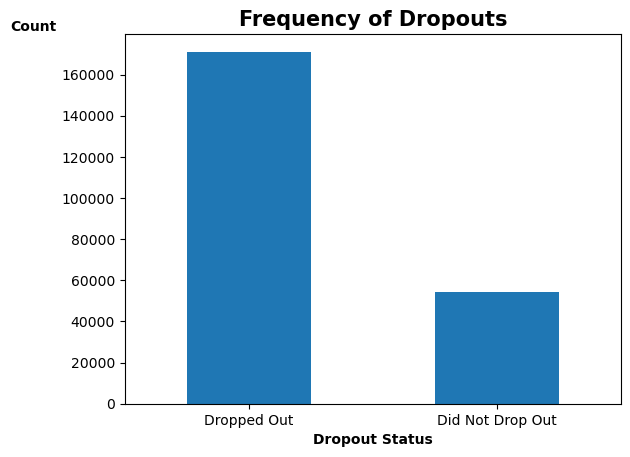

In [7]:
truth = final_df.loc[:,['truth']]
truth_counts = truth.apply(pd.value_counts)

truth_counts.plot.bar()
plt.title("Frequency of Dropouts", weight = "bold", fontsize = 15)
plt.xlabel("Dropout Status", weight = "bold", fontsize = 10)
plt.ylabel("Count", rotation = 0, weight = "bold", fontsize = 10, loc = 'top')
x_labels = ['Dropped Out', 'Did Not Drop Out']
plt.xticks(rotation = 0, ticks = [0, 1], labels = x_labels)
plt.legend('', frameon = False)

From the graph, we can conlude that the number of students who dropped out far exceeds the number of students who did not.

Now, the graph of the frequency of occurences of each action variable (how many times the value 1 occured for each action).

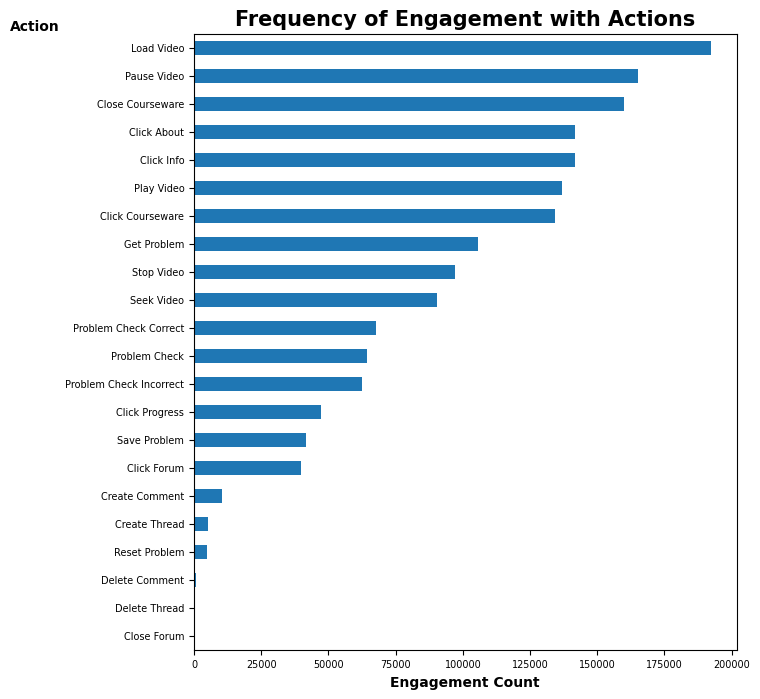

In [8]:
truthless = final_df.iloc[:, 0:22]
counts = truthless.apply(pd.value_counts)
positive_counts = counts.drop([0])
positive_counts_transposed = positive_counts.T
positive_counts_transposed = positive_counts_transposed.sort_values(by = 1)

positive_counts_transposed.plot.barh(figsize = (7, 8))
plt.title("Frequency of Engagement with Actions", weight = "bold", fontsize = 15)
plt.xlabel("Engagement Count", weight = "bold", fontsize = 10)
plt.ylabel("Action", rotation = 0, weight = "bold", fontsize = 10, loc = 'top')
plt.xticks(fontsize = 7)
y_labels = ['Load Video', 'Pause Video', 'Close Courseware', 'Click About', 'Click Info', 'Play Video', 'Click Courseware', 'Get Problem', 'Stop Video',
            'Seek Video', 'Problem Check Correct', 'Problem Check','Problem Check Incorrect', 'Click Progress', 'Save Problem', 'Click Forum',
            'Create Comment', 'Create Thread', 'Reset Problem', 'Delete Comment', 'Delete Thread', 'Close Forum']
plt.yticks(fontsize = 7, ticks = [21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], labels = y_labels)
plt.legend('', frameon = False)

Finally, a correlation analysis of between each action variable and the 'truth' variable. Such an analysis can give us an indication of which variables are related to the target variable, and which are not.  

,Correlation with Truth
truth,1.000000
close_forum,-0.003942
click_about,-0.028487
delete_thread,-0.039782
delete_comment,-0.080973
reset_problem,-0.087465
load_video,-0.112917
create_thread,-0.151118
click_info,-0.152983
pause_video,-0.169706


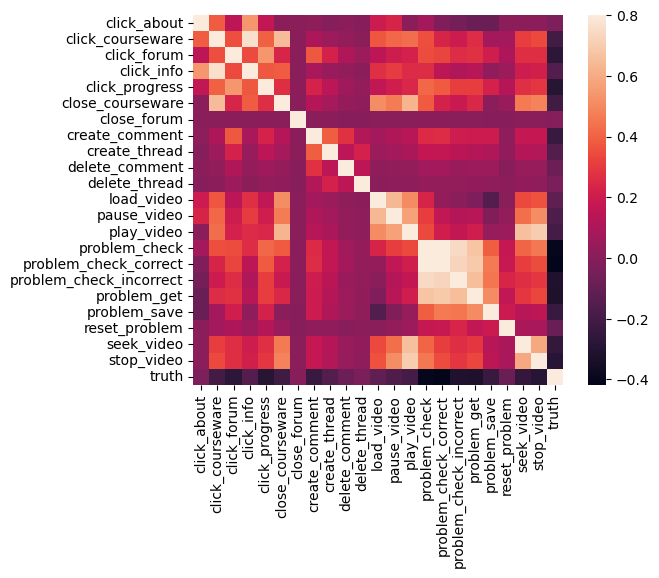

In [9]:
correlation = final_df.corr()
sns.heatmap(correlation, square = True, vmax = 0.8)
correlation_df = pd.DataFrame(correlation['truth'].sort_values(ascending = False))
correlation_df.rename(columns = {'truth' : 'Correlation with Truth'})

Based on the values in the table, interacting with the practise problems available to the students seems to have the strongest, albeit negative, corrlation with the truth variable. Moreover, all of the action variables are negatively correlated with the truth variable, meaning that as a student increases their engagement with each individual action, the less likely they are to drop out (because the highest the value for truth, the higher the likelood of dropping out). From the correlation heatmap, we can get a good idea of which of the action variables are stongly correlated with one another. Specifically, we can see that the different action related to the practise problems are strongly and positively correlated with one another. On the other hand, the actions related to the video content is negatively, and somewhat strongly correlted to the comment and thread actions. These conlusion could prove valuable in the later stages of the analysis, specifically when deciding which students fit into which learning styles based on their actions. 

## Principal Component Analysis

In [124]:
# Train/test split
X = final_df.iloc[:, 0:22]
y = final_df.loc[:,['truth']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2002)

A note on standardization: The computation associated with principal component analysis is based on variance, and as such, it is necessary to standerdize the data before performing PCA on it. However, in the case of the data being used in this analysis, it is all binary without expection, and so there is not need to standerdize.

In [109]:
def create_pca_df(trainx):
    # Generation of principal components
    pca = PCA(n_components = 5)
    X_train_pc = pca.fit_transform(trainx)

    # Data frame of the 5 principal components
    pca_df_1 = pd.DataFrame(pca.components_, columns = trainx.columns)
    pca_df_2 = pca_df_1.T
    pca_df_2 = pca_df_2.rename(columns = {0 : 'pc_1', 1 : 'pc_2', 2 : 'pc_3', 3 : 'pc_4', 4 : 'pc_5'})
    
    return pca_df_2

In [110]:
create_pca_df(X_train)

,pc_1,pc_2,pc_3,pc_4,pc_5
click_about,0.081147,-0.278594,0.487862,-0.602760,-0.082513
click_courseware,0.303985,-0.261527,0.304451,0.389029,-0.142916
click_forum,0.172368,0.018270,0.152830,0.047199,0.568833
click_info,0.232253,-0.275504,0.454379,0.149187,-0.006472
click_progress,0.202012,0.030980,0.185330,0.067485,0.549406
close_courseware,0.283343,-0.197063,-0.126367,0.478645,-0.211653
close_forum,0.000032,0.000020,-0.000003,-0.000036,0.000064
create_comment,0.054493,0.036885,0.012240,-0.018502,0.138125
create_thread,0.024688,0.017457,0.000048,-0.007699,0.058169
delete_comment,0.004319,0.002707,0.002125,-0.001282,0.012166


The reason why I chose 5 components was due to conclusions made in published literature pertaining to student learning preferences. Specifically, it was found that students can be categorized into one of five different learning style groups based on their in class behaviour. As such, it seems like the sensible option to split the data in the manner portrayed in the above data frame. 

# Further Exploratory Data Analysis: Factor Analysis

In this section, I explore the possibility of matching the principal components found in the previous section with the each of the five learning styles refrenced in the literature. This is to simply gain a better understanding of the data, and how it relates to already published literature on the topic. To do this, I employ factor analysis in order to build five loading diagrams for each component.

In [13]:
# Perform adequacy test using Bartlett's test
chi_square_value, p_value = calculate_bartlett_sphericity(X_train)
chi_square_value, p_value

(1685940.3406739056, 0.0)

This test was statisitically significant as the p-value is 0, which means that the correlation matrix for this data set is not an identity matrix.

In [14]:
# Perform suitability test using KMO test
kmo_all, kmo_model = calculate_kmo(X_train)
kmo_model

/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8562950691726188

KMO value indicates that we can proceed with the factor analysis.

In [115]:
# Functions
def get_pc_values(trainx):
    # Generation of factor analysis object and performance of factor analysis
    fa = FactorAnalyzer()
    fa.set_params(n_factors = 5, rotation = "varimax")
    fa.fit(trainx)

    # Sow loadings for each factor
    fa_df_1 = pd.DataFrame(fa.loadings_.T, columns = trainx.columns)
    fa_df_2 = fa_df_1.T.rename(columns = {0 : 'pc_1', 1 : 'pc_2', 2 : 'pc_3', 3 : 'pc_4', 4 : 'pc_5'})

    # Split data frame by column
    pc_1 = pd.DataFrame(fa_df_2['pc_1'])
    pc_2 = pd.DataFrame(fa_df_2['pc_2'])
    pc_3 = pd.DataFrame(fa_df_2['pc_3'])
    pc_4 = pd.DataFrame(fa_df_2['pc_4'])
    pc_5 = pd.DataFrame(fa_df_2['pc_5'])

    # Arrange data frames in ascending order
    pc_1 = pc_1.sort_values(by = 'pc_1')
    pc_2 = pc_2.sort_values(by = 'pc_2')
    pc_3 = pc_3.sort_values(by = 'pc_3')
    pc_4 = pc_4.sort_values(by = 'pc_4')
    pc_5 = pc_5.sort_values(by = 'pc_5')

    # Extracting values from data frames
    index_1 = pc_1.index.tolist()
    index_2 = pc_2.index.tolist()
    index_3 = pc_3.index.tolist()
    index_4 = pc_4.index.tolist()
    index_5 = pc_5.index.tolist()

    pc_1_values = pc_1['pc_1'].tolist()
    pc_2_values = pc_2['pc_2'].tolist()
    pc_3_values = pc_3['pc_3'].tolist()
    pc_4_values = pc_4['pc_4'].tolist()
    pc_5_values = pc_5['pc_5'].tolist()
    
    return [pc_1_values, pc_2_values, pc_3_values, pc_4_values, pc_5_values]


def plot_factor_loading_figures(pc_value):
    plt.figure(figsize = (7, 8))
    plt.scatter(pc_value, index_1, s = 80)
    plt.title("Loadings for First Factor/Component", weight = "bold", fontsize = 15)
    plt.xlabel("Loadings", weight = "bold", fontsize = 10)
    plt.ylabel("Action", rotation = 0, weight = "bold", fontsize = 10, loc = 'top')
    plt.xticks(fontsize = 7)
    plt.yticks(fontsize = 7)
    plt.show()
    
    return None

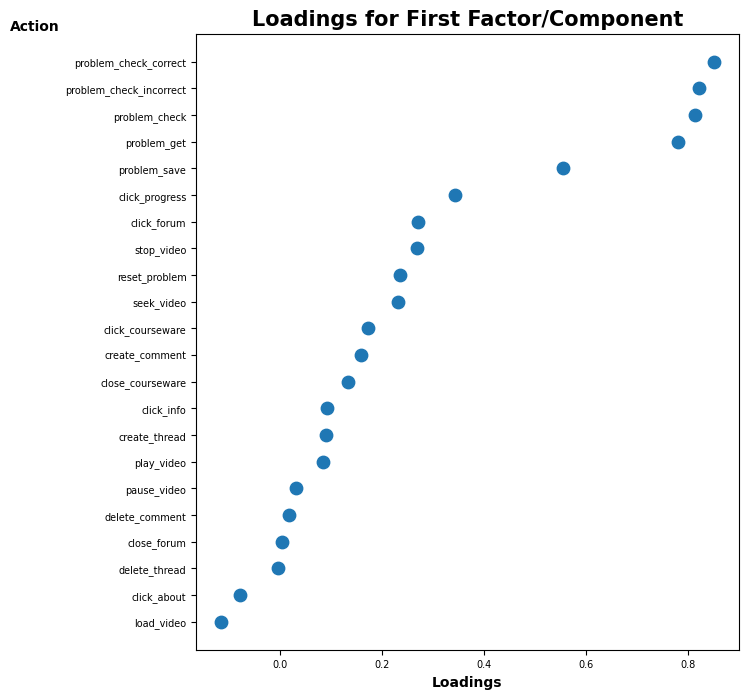

In [117]:
pc_values = get_pc_values(X_train)
plot_factor_loading_figures(pc_values[0])

In this PC, there is a high amount of relative weight on the learning behaviours assocaied with practise problem engagement. As such, this component closely matches with the reflective and solitary learning styles.

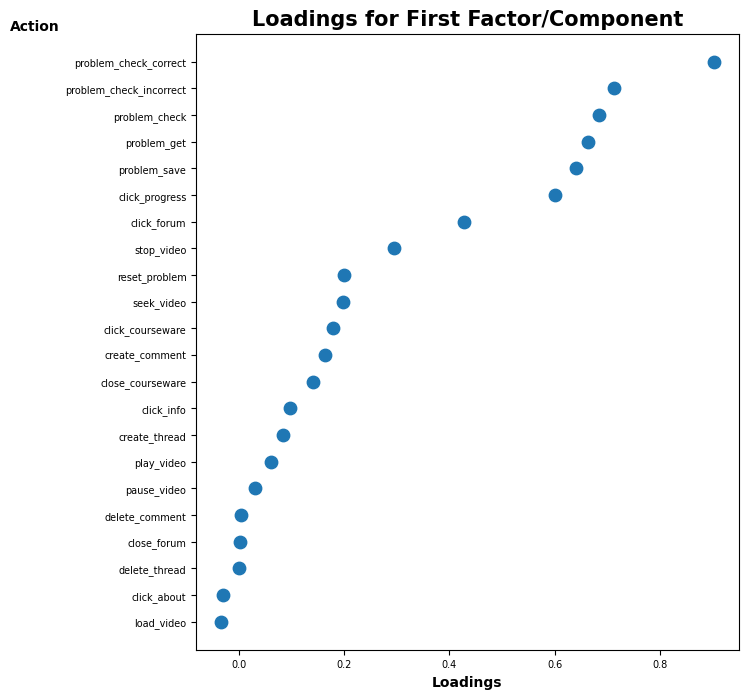

In [118]:
plot_factor_loading_figures(pc_values[1])

This PC reflects an abundance of relative weight on engagement with video content, which matches with the sensory and visual learning styles.

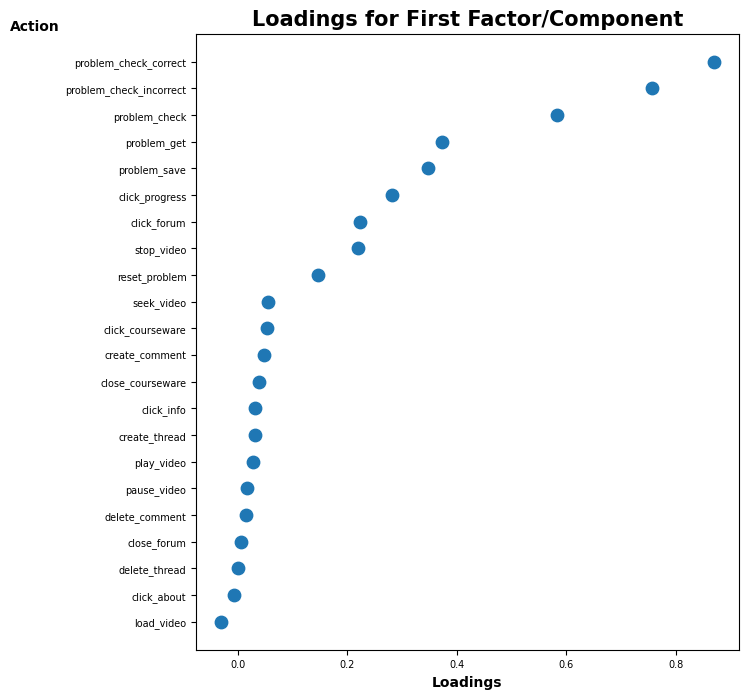

In [119]:
plot_factor_loading_figures(pc_values[2])

Here, actions related to button clicking is given high relative weight, which matches with the integrated and verbal learning styles.

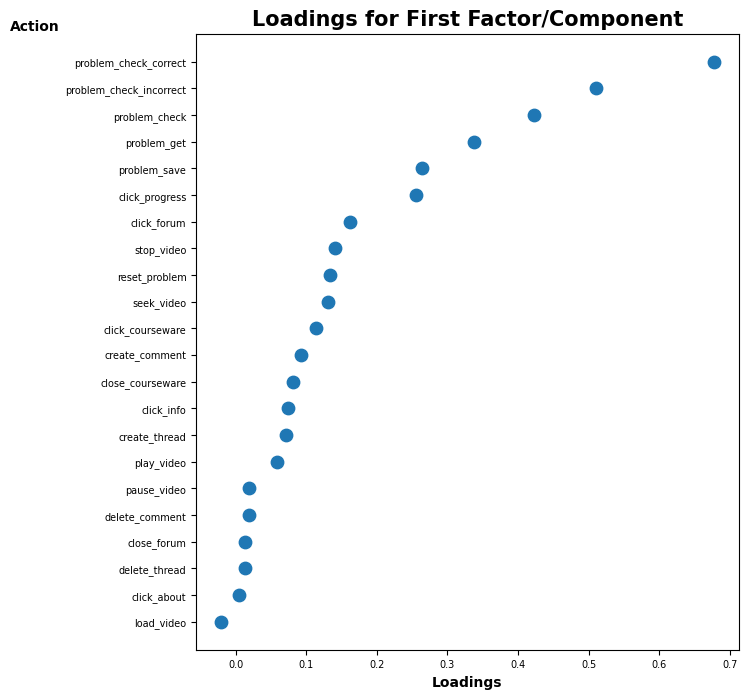

In [120]:
plot_factor_loading_figures(pc_values[3])

The fourth PC gives high relative weight to engagement with comments, threads, and forums, therefore matching up with the active and social learning styles.

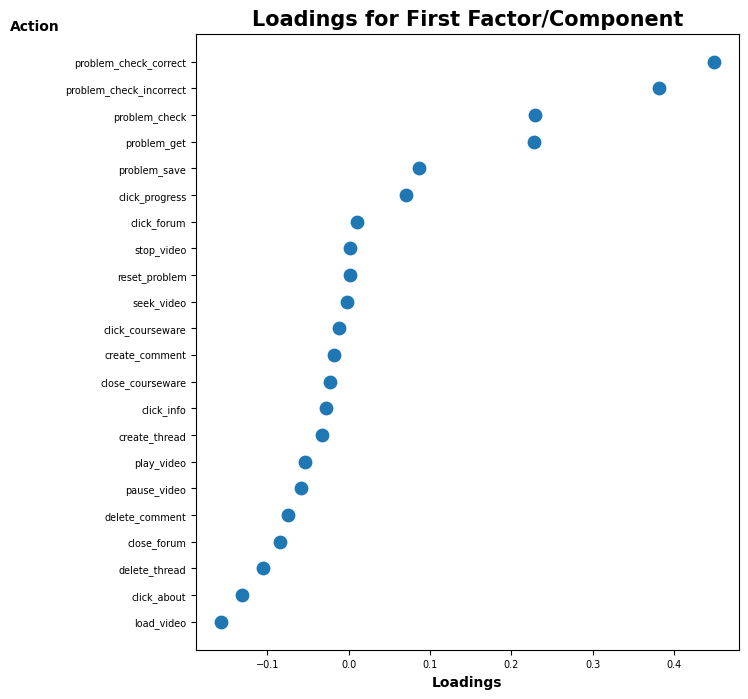

In [121]:
plot_factor_loading_figures(pc_values[4])

The final PC gives high relative weight to abtract activities like 'click_about' while giving low relative weight to actions involving engagement with comprehensive pages like 'click_courseware'. As such, this PC matches up with the sequential and intuitive learning styles.

The categorizations were based on the following research:


**Active/reflective learning style and e-learning behavior**
"A learning style can be recognized by users’ learning behaviors on forums, wikis, and homework in the active/reflective dimension. Generally, active learners tend to have more posts, post replies and post views in the forum, while reflective learners prefer to think in private and tend to read posts instead of posting. This approach can also be used to recognize active/reflective learners. A wiki is an important feature through which teachers can instruct students by providing key information. When teachers make an entry, students can revise and extend its definition, connotation and denotation, in the course of which each change to the wiki view and all the wiki edits are recorded. Active learners are inclined to try more wiki functions and continually revise the entry. In contrast, reflective learners analyze each question carefully and look up wiki entries more than they revise or update them. Regarding homework, data concerning the time an assignment is submitted before the home- work deadline and the frequency of completed homework problems are collected".

**Sensitive/intuitive learning style and E-learning behavior**
"The number of users’ video views, textbook views, outline views, K-Map views, homework dealing, homework review, and introduction view. Sensitive learners are more likely to review their homework carefully, spend more time on doing homework and deal with practical cases such as video, textbook and K-map. Intuitive learners are more creative. They prefer abstract ideas and would like to spend more time on them. Therefore, we can recognize an intuitive learning style by the visit frequency for such abstract resources as K-maps, outline views, and course introductions".

**Visual/verbal learning style and e-learning behavior**
"The users’ video play time is recorded as well as the frequency of video views, K-map views, textbook views, wiki views, wiki edits and introduction views. Verbal learners are more inclined to read text messages such as course book listings, course introductions, wiki edits and views, while visual learners prefer materials such as graphs, tables and videos. As a result, the time they spend on video and the frequency with which they check K-maps tend to be larger".

**Sequential/global learning style and e-learning behavior**
"Outline views, introduction views, button clicks and tables of contents views are collected to help determine whether the learning style is sequential or global. Global learners normally visit comprehensive introduction pages, such as outline views and intro- duction views, while sequential learners visit fewer such pages. Sequential learners prefer to click buttons, while global learners prefer to navigate by clicking catalogue links".

**Social/solitary learning style and e-learning behavior**
"From a social interaction perspective, learners can be divided into social and solitary types. These two types are distinguishable by number of posts, forum visits, replies, post views, post replied to, posts viewed by, self-homework views, charts, and chart replies. Social learners like to communicate with others, while solitary learners prefer to study alone. Therefore, social learners tend to be more active in discussion areas. They communicate with others frequently by posting, replying to posts and using built-in chat tools. They also maintain good relationships with others through their posts, post replies and chats. Solitary learners are much less active than their social counterparts and more likely to focus on their own homework. These learners have fewer posts, post replied to, viewed by, and fewer chat messages".

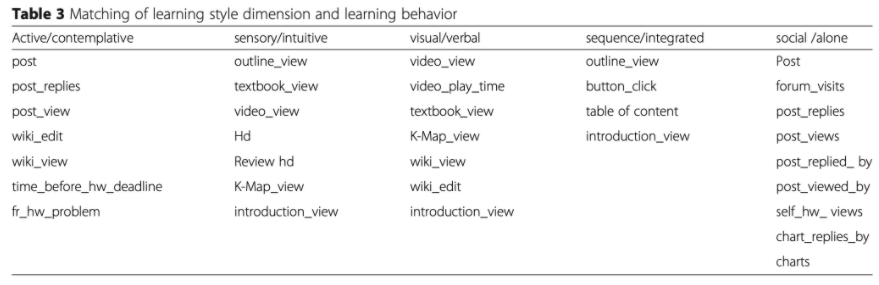

(Source: A learning style classification approach based on deep belief network for large-scale online education  - Hao Zhang, Tao Huang, Sanya Liu, Hao Yin, Jia Li1, Huali Yang and Yu Xia)

In [20]:
# Rename PCA columns names according to assigned learning styles
fa_df_2 = fa_df_1.T.rename(columns = {0 : 'Reflective and Solitary', 1 : 'Sensory and Visual',
                                      2 : 'Integrated and Verbal', 3 : 'Active and Social',
                                      4 : 'Seuqential and Intuitive'})
fa_df_2

,Reflective and Solitary,Sensory and Visual,Integrated and Verbal,Active and Social,Seuqential and Intuitive
click_about,-0.078508,-0.033738,0.583532,0.013066,0.228259
click_courseware,0.172646,0.427168,0.756986,-0.020812,-0.075297
click_forum,0.271541,0.178203,0.347555,0.422656,-0.131569
click_info,0.092168,0.199215,0.869740,0.013276,-0.023275
click_progress,0.343041,0.198427,0.373138,0.264453,-0.105177
close_courseware,0.134420,0.683227,0.281416,0.019104,-0.018536
close_forum,0.003691,0.002940,-0.000074,0.018791,0.001625
create_comment,0.159775,0.084381,0.052794,0.677444,-0.027897
create_thread,0.090690,0.060721,0.006683,0.510650,-0.002057
delete_comment,0.016944,0.005342,0.017070,0.337159,0.002130


# Principal Component Regression

Now to predict the actual target variable.

In [89]:
# Functions
def predict_for_pcr(trainx, trainy, testx, testy):
    # Train the model with the 5 principal components
    lin_reg_pc = LinearRegression()
    lin_reg_pc.fit(trainx, trainy)

    # Cross validation on the training set
    cv = KFold(n_splits = 10, shuffle = True, random_state = 2002)
    pcr_score_train = -1 * cross_val_score(estimator = lin_reg_pc, X = trainx, y = trainy, 
                                       cv = cv, scoring = 'neg_root_mean_squared_error').mean()

    # Tranform test data
    X_test_pc = pca.transform(testx)

    # Predict 
    preds_test = lin_reg_pc.predict(X_test_pc)
    preds_test = np.round(preds_test)

    preds_train = lin_reg_pc.predict(trainx)
    preds_train = np.round(preds_train)
    
    return [preds_train, preds_test]


def get_mse_for_pcr(trainy, testy, trainp, testp):
    pcr_score_train = mean_squared_error(trainy, trainp, squared = False)
    pcr_score_test = mean_squared_error(testy, testp, squared = False)
    
    return[pcr_score_train, pcr_score_test]


def create_df_with_preds_and_truths(testy, testp):
    truth_series = testy['truth']
    truth_series = pd.DataFrame(truth_series)
    truth_series['truth_predicted'] = testp
    truth_series = truth_series.sort_values(by = "enroll_id")

    return truth_series


def create_frequency_chart(truth_df):
    predicted_truth_count = truth_df['truth_predicted'].value_counts()
    predicted_truth_count.plot.bar()
    plt.title("Frequency of Predicted Dropouts", weight = "bold", fontsize = 15)
    plt.xlabel("Predicted Dropout Status", weight = "bold", fontsize = 10)
    plt.ylabel("Count", rotation = 0, weight = "bold", fontsize = 10, loc = 'top')
    x_labels = ['Drop Out', 'Non Drop Out']
    plt.xticks(rotation = 0, ticks = [0, 1], labels = x_labels)
    plt.legend('', frameon = False)
    
    return None


def create_rmse_df(trains, tests):
    data = {'RMSE Data Set': ['Train', 'Test'], 'RMSE value': [trains, tests]}
    rmse_data = pd.DataFrame(data)
    
    return rmse_data

In [102]:
model_preds = predict_for_pcr(X_train_pc, y_train, X_test, y_test)
mse_scores = get_mse_for_pcr(y_train, y_test, model_preds[0], model_preds[1])
truths_and_predicted_df = create_df_with_preds_and_truths(y_test, model_preds[1])
truths_and_predicted_df

,truth,truth_predicted
enroll_id,,
772,1.0,1.0
776,0.0,1.0
778,0.0,1.0
780,1.0,1.0
786,0.0,1.0
...,...,...
466738,1.0,1.0
466745,1.0,1.0
466771,1.0,1.0


The predicted high risk status resulting from the model's calculations is a decimal between 0 and 1. This is because the model treats the 0 and 1 as two ends of the likelihood spectrum with regards to each student. Meaning, if a student is assigned a predicted value of 0.75 for their truth variable, this means that they are 75% likely to drop out (since 0 means not drop out, and 1 means drop out). Thus, the predicted value is rounded to the nearest whole number so as to predict the student with one of the two values found in the original data set.

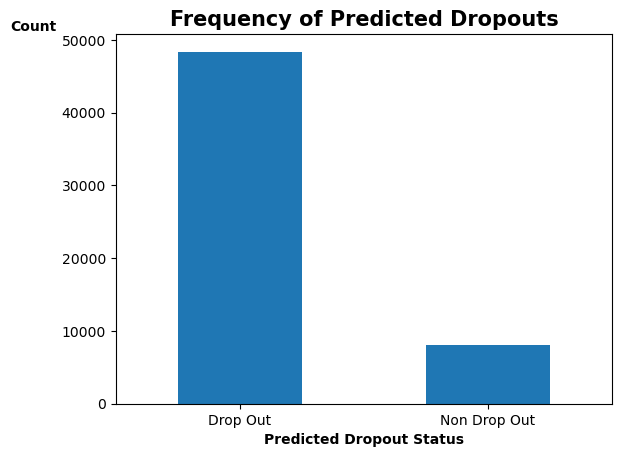

In [100]:
create_frequency_chart(truths_and_predicted_df)

The proportions of predicted drop outs vs non drop outs are similar to that of the actual data set, which is another great sign that the model is a good one.

As it relates to the PCR model, the test RMSE is low, which is a great sign that the model is working well. Further, the RMSE values for both the training and test sets are very similar to one another, which further indicates that the model is a good one.

In [101]:
create_rmse_df(mse_scores[0], mse_scores[1])

,RMSE Data Set,RMSE value
0,Train,0.451892
1,Test,0.452882


In [27]:
# Build PCR equation with coefficients
beta_0 = lin_reg_pc.intercept_
beta_0 = beta_0.tolist()
beta_0 = beta_0[0]

betas = lin_reg_pc.coef_[0]
betas = betas.tolist()

print(f"Fit model: high risk status = {beta_0} {betas[0]}(PC1) {betas[1]}(PC2) {betas[2]}(PC3) + {betas[3]}(PC4) {betas[4]}(PC5), with the high risk status rounded to the nearest whole number")

Fit model: high risk status = 0.7588444197576094 -0.15947524787102313(PC1) -0.10103892836570237(PC2) -0.02265579476635301(PC3) + 0.03333762960147912(PC4) -0.0815385621143382(PC5), with the high risk status rounded to the nearest whole number


## Classification

One possible reason behind the model's low accuracy could be that a regression model was used when a classification model is more appropriate. Below I try to use the classificatioion model to see if the results differ, ultimatley re-doing the above analysis but this time by way of logistic regression.

In [103]:
# New Function
def predict_for_classification(trainx, trainy, testx, testy):
    # Train the model with the 5 principal components
    lin_reg_pc = LogisticRegression()
    lin_reg_pc.fit(trainx, trainy)

    # Cross validation on the training set
    cv = KFold(n_splits = 10, shuffle = True, random_state = 2002)
    pcr_score_train = -1 * cross_val_score(estimator = lin_reg_pc, X = trainx, y = trainy, 
                                       cv = cv, scoring = 'neg_root_mean_squared_error').mean()

    # Tranform test data
    X_test_pc = pca.transform(testx)

    # Predict 
    preds_test = lin_reg_pc.predict(X_test_pc)
    preds_test = np.round(preds_test)

    preds_train = lin_reg_pc.predict(trainx)
    preds_train = np.round(preds_train)
    
    return [preds_train, preds_test]

In [104]:
model_preds_2 = predict_for_classification(X_train_pc, y_train, X_test, y_test)
mse_scores_2 = get_mse_for_pcr(y_train, y_test, model_preds_2[0], model_preds_2[1])
truths_and_predicted_df_2 = create_df_with_preds_and_truths(y_test, model_preds_2[1])
truths_and_predicted_df_2

/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/s

,truth,truth_predicted
enroll_id,,
772,1.0,1.0
776,0.0,1.0
778,0.0,1.0
780,1.0,1.0
786,0.0,1.0
...,...,...
466738,1.0,1.0
466745,1.0,1.0
466771,1.0,1.0


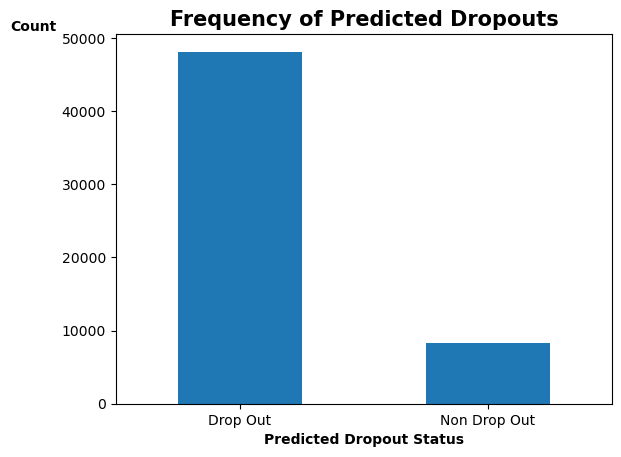

In [105]:
create_frequency_chart(truths_and_predicted_df_2)

In [106]:
create_rmse_df(mse_scores_2[0], mse_scores_2[1])

,RMSE Data Set,RMSE value
0,Train,0.452009
1,Test,0.453293


There seems to be not much of a difference, and so other changes to the model should be explored.

## Balancing Classes

In an attempt to improve the model, I balance the classes (dropouts vs non-dropouts) and then re-do the analysis.

In [62]:
# Find out number of observations with 0 for truth column
num_of_zeroes = truth_counts.iloc[1, 0]

# Separate values equaling 1 for truth columns
just_ones = final_df.loc[final_df['truth'] == 1]

# Selecting same number of rows as number of observations with 0 for truth column
just_ones_df = just_ones.iloc[:num_of_zeroes, :]

# Separate values equaling 0 for truth columns
just_zeroes = final_df.loc[final_df['truth'] == 0]

# Combining the 2 dataframes
balanced_df = pd.concat([just_ones_df, just_zeroes]).sort_values(by = "enroll_id")
balanced_df

,click_about,click_courseware,click_forum,click_info,click_progress,close_courseware,close_forum,create_comment,create_thread,delete_comment,...,play_video,problem_check,problem_check_correct,problem_check_incorrect,problem_get,problem_save,reset_problem,seek_video,stop_video,truth
enroll_id,,,,,,,,,,,,,,,,,,,,,
772,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
773,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
774,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
775,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
776,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466725,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
466749,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
466754,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Principal Component Regression with Balanced Classes

In [123]:
# Train/test split
X2 = balanced_df.iloc[:, 0:22]
y2 = balanced_df.loc[:,['truth']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25, random_state = 2002)

In [126]:
balanced_pca = create_pca_df(X_train2)
# Rename PCA columns names according to assigned learning styles
balanced_pca_2 = balanced_pca.rename(columns = {'pc_1' : 'Reflective and Solitary', 'pc_2' : 'Sensory and Visual',
                                      'pc_3' : 'Integrated and Verbal', 'pc_4' : 'Active and Social',
                                      'pc_5' : 'Seuqential and Intuitive'})
balanced_pca_2

,Reflective and Solitary,Sensory and Visual,Integrated and Verbal,Active and Social,Seuqential and Intuitive
click_about,0.116345,-0.192616,0.521253,-0.217491,0.624293
click_courseware,0.288122,-0.210439,0.348127,-0.103769,-0.363718
click_forum,0.204598,0.005523,0.144655,0.621609,0.001365
click_info,0.240255,-0.203389,0.463763,-0.047452,-0.130958
click_progress,0.238101,0.023871,0.165467,0.535716,-0.069277
close_courseware,0.229393,-0.227321,-0.108801,-0.119398,-0.503370
close_forum,0.000023,0.000017,-0.000035,0.000030,0.000025
create_comment,0.074496,0.033101,-0.003329,0.226647,0.052157
create_thread,0.031549,0.013643,-0.007706,0.093834,0.012973
delete_comment,0.006707,0.002698,0.001774,0.022340,0.004801


In [128]:
X_train_pc_balanced = pca.fit_transform(X_train2)

model_preds_balanced = predict_for_pcr(X_train_pc_balanced, y_train2, X_test2, y_test2)
mse_scores_balanced = get_mse_for_pcr(y_train2, y_test2, model_preds_balanced[0], model_preds_balanced[1])
truths_and_predicted_df_balanced = create_df_with_preds_and_truths(y_test2, model_preds_balanced[1])
truths_and_predicted_df_balanced

,truth,truth_predicted
enroll_id,,
776,0.0,1.0
785,1.0,1.0
786,0.0,1.0
802,1.0,1.0
806,1.0,1.0
...,...,...
466594,0.0,0.0
466688,0.0,0.0
466749,0.0,0.0


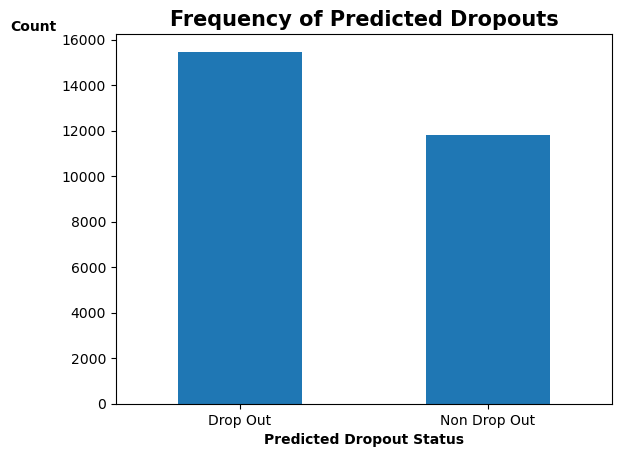

In [129]:
create_frequency_chart(truths_and_predicted_df_balanced)

This time the proportions are different from the original data set.

In [130]:
create_rmse_df(mse_scores_balanced[0], mse_scores_balanced[1])

,RMSE Data Set,RMSE value
0,Train,0.516416
1,Test,0.513726


As can be seen, there is a significant improvement in the quality of the model.

## Classification with Balanced Classes

In [131]:
model_preds_balanced_2 = predict_for_classification(X_train_pc_balanced, y_train2, X_test2, y_test2)
mse_scores_balanced_2 = get_mse_for_pcr(y_train2, y_test2, model_preds_balanced_2[0], model_preds_balanced_2[1])
truths_and_predicted_df_balanced_2 = create_df_with_preds_and_truths(y_test2, model_preds_balanced_2[1])
truths_and_predicted_df_balanced_2

/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/azizalkorey/Library/jupyterlab-desktop/jlab_server/lib/python3.8/s

,truth,truth_predicted
enroll_id,,
776,0.0,1.0
785,1.0,1.0
786,0.0,1.0
802,1.0,1.0
806,1.0,1.0
...,...,...
466594,0.0,0.0
466688,0.0,0.0
466749,0.0,0.0


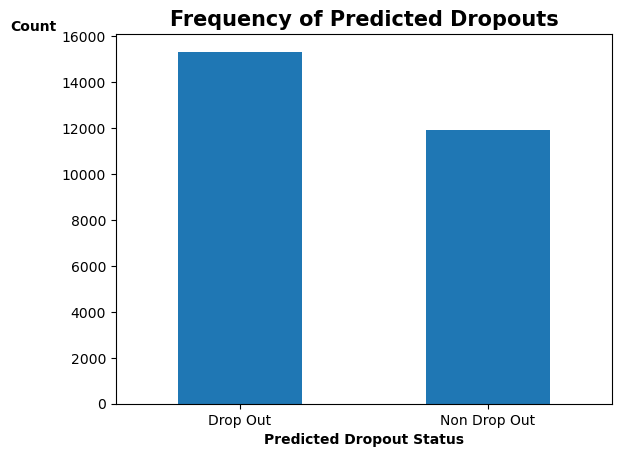

In [132]:
create_frequency_chart(truths_and_predicted_df_balanced_2)

In [133]:
create_rmse_df(mse_scores_balanced_2[0], mse_scores_balanced_2[1])

,RMSE Data Set,RMSE value
0,Train,0.516676
1,Test,0.513298


Once again, there seems to be no difference in the RMSE values when comparing linear and logistic regression models.

## Discussion

The model built in this project can take information concerning the actions of a group of students in an onlinelearning environment, and use them to predict weather each student will likely fail, and as such be categorized as high-risk, or not fail, and as such be categorized as non high-risk, in an efficient manner (as per the RMSE model). Such a model can possibly be a useful tool for teachers to use in an effort to personalize the online learning experience for students.

Initially, the first principal component regression yieled a low accuracy level, and so I experimented with a classification model to see if the accuracy would improve. It did not, and this could possibly be because the structure of the two models were so similar due to my target variable being binary. I then balanced the classes found in the initial data set as a second attempt at improving the model, and this time experienced success. This is likely because when the classes were not balanced, the model favored the larger class (the drop outs) which then negatively impacted the predictions' accuracy. Once again however, using a classification model on the balanced data made no significant improvement, likely for the same reason mentioned before.

## References

1) Zhang, Hao, et al. “A Learning Style Classification Approach Based on Deep Belief Network for Large-Scale Online Education.” Journal of Cloud Computing, vol. 9, no. 1, 2020, https://doi.org/10.1186/s13677-020-00165-y. 